In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import h2o
from h2o.frame import H2OFrame
from sklearn.metrics import auc, roc_curve, classification_report
from h2o.estimators.random_forest import H2ORandomForestEstimator

Load Data

In [4]:
email_opened = pd.read_csv("../Collection of DS take home challenges/data collection-Product dataset数据挑战数据集/ML Email Marketing Campaign/email_opened_table.csv")
email = pd.read_csv("../Collection of DS take home challenges/data collection-Product dataset数据挑战数据集/ML Email Marketing Campaign/email_table.csv")
link_clicked = pd.read_csv("../Collection of DS take home challenges/data collection-Product dataset数据挑战数据集/ML Email Marketing Campaign/link_clicked_table.csv")

In [5]:
email.head()

,email_id,email_text,email_version,hour,weekday,user_country,user_past_purchases
0,85120,short_email,personalized,2,Sunday,US,5
1,966622,long_email,personalized,12,Sunday,UK,2
2,777221,long_email,personalized,11,Wednesday,US,2
3,493711,short_email,generic,6,Monday,UK,1
4,106887,long_email,generic,14,Monday,US,6


In [6]:
email.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   email_id             100000 non-null  int64 
 1   email_text           100000 non-null  object
 2   email_version        100000 non-null  object
 3   hour                 100000 non-null  int64 
 4   weekday              100000 non-null  object
 5   user_country         100000 non-null  object
 6   user_past_purchases  100000 non-null  int64 
dtypes: int64(3), object(4)
memory usage: 5.3+ MB


In [7]:
for i in ["email_text", "email_version", "hour", "weekday", "user_country"]:
    uniques = sorted(email[i].unique())
    print("{0:20s} {1:10d}\t {2}".format(i, len(uniques), uniques[:10]))

email_text                    2	 ['long_email', 'short_email']
email_version                 2	 ['generic', 'personalized']
hour                         24	 [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
weekday                       7	 ['Friday', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday']
user_country                  4	 ['ES', 'FR', 'UK', 'US']


In [8]:
email_opened.head()

,email_id
0,284534
1,609056
2,220820
3,905936
4,164034


In [9]:
len(email_opened["email_id"].unique())

10345

In [10]:
link_clicked.head()

,email_id
0,609056
1,870980
2,935124
3,158501
4,177561


In [11]:
len(link_clicked["email_id"].unique())

2119

In [12]:
email_opened["open"] = 1
link_clicked["click"] = 1

email = email.merge(email_opened, how = "left", on = "email_id").merge(link_clicked, how = "left", on = "email_id")

In [13]:
email = email.fillna(0)

In [14]:
print("open rate: {}%".format(email.open.mean()*100))
print("click rate: {}%".format(email.click.mean()*100))

open rate: 10.345%
click rate: 2.119%


In [15]:
print("{}% of opened email was clicked".format(round(100*sum(email.click)/sum(email.open), 2)))

20.48% of opened email was clicked


EDA

In [16]:
email.head()

,email_id,email_text,email_version,hour,weekday,user_country,user_past_purchases,open,click
0,85120,short_email,personalized,2,Sunday,US,5,0.0,0.0
1,966622,long_email,personalized,12,Sunday,UK,2,1.0,1.0
2,777221,long_email,personalized,11,Wednesday,US,2,0.0,0.0
3,493711,short_email,generic,6,Monday,UK,1,0.0,0.0
4,106887,long_email,generic,14,Monday,US,6,0.0,0.0


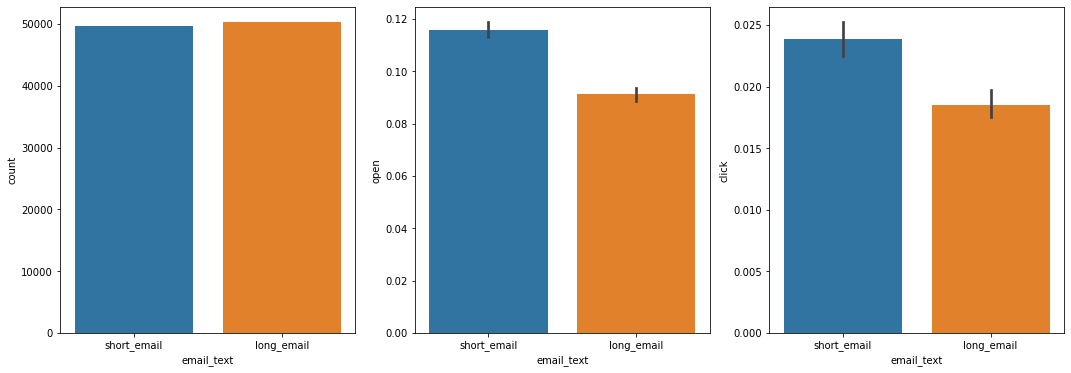

In [17]:
fig, axs = plt.subplots(1, 3, figsize = (18,6))

sns.countplot(x = "email_text", data = email, ax = axs[0])
sns.barplot(x = "email_text", y = "open", data = email, ax = axs[1])
sns.barplot(x = "email_text", y = "click", data = email, ax = axs[2])

plt.show()

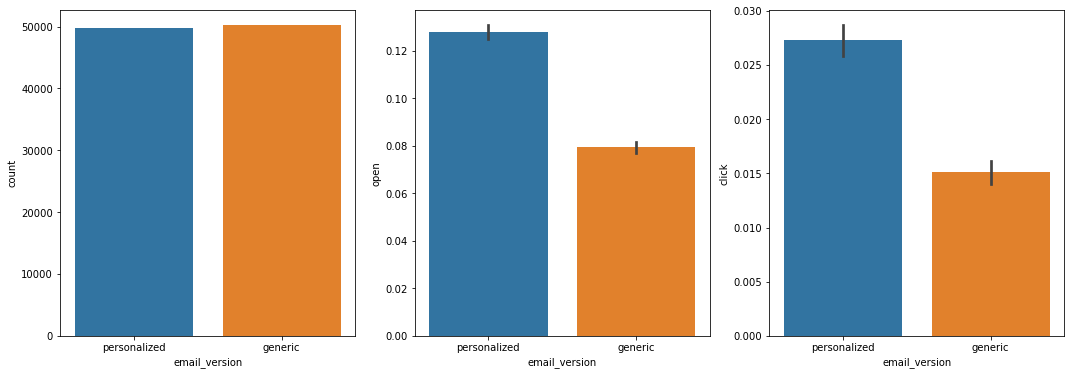

In [18]:
fig, axs = plt.subplots(1, 3, figsize = (18,6))

sns.countplot(x = "email_version", data = email, ax = axs[0])
sns.barplot(x = "email_version", y = "open", data = email, ax = axs[1])
sns.barplot(x = "email_version", y = "click", data = email, ax = axs[2])

plt.show()

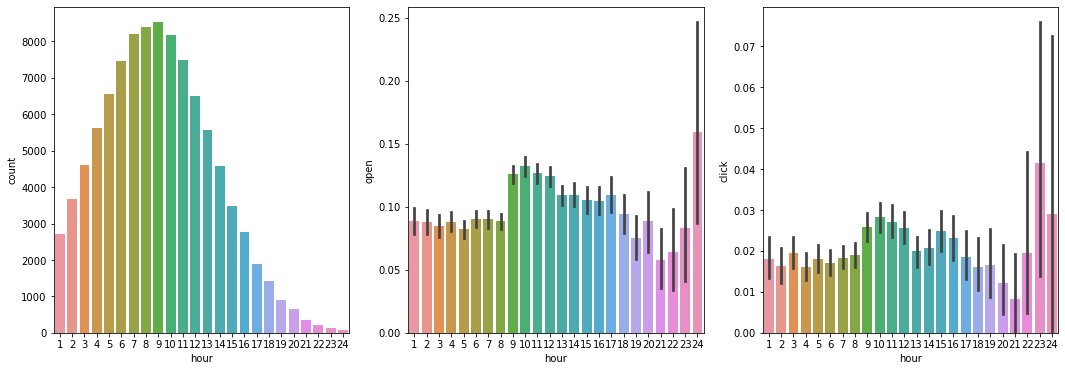

In [19]:
fig, axs = plt.subplots(1, 3, figsize = (18,6))

sns.countplot(x = "hour", data = email, ax = axs[0])
sns.barplot(x = "hour", y = "open", data = email, ax = axs[1])
sns.barplot(x = "hour", y = "click", data = email, ax = axs[2])

plt.show()

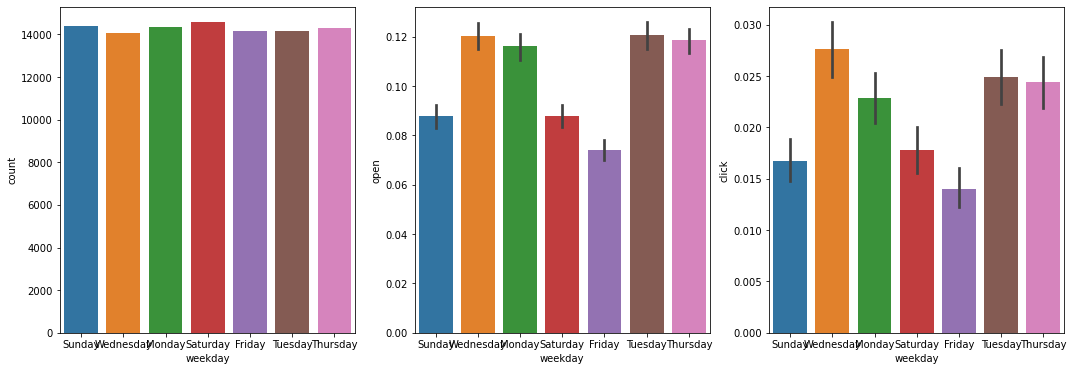

In [20]:
fig, axs = plt.subplots(1, 3, figsize = (18,6))

sns.countplot(x = "weekday", data = email, ax = axs[0])
sns.barplot(x = "weekday", y = "open", data = email, ax = axs[1])
sns.barplot(x = "weekday", y = "click", data = email, ax = axs[2])

plt.show()

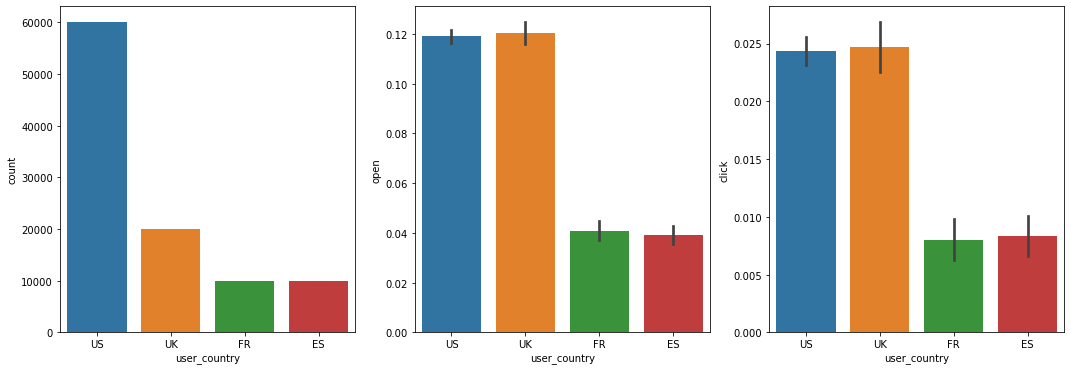

In [21]:
fig, axs = plt.subplots(1, 3, figsize = (18,6))

sns.countplot(x = "user_country", data = email, ax = axs[0])
sns.barplot(x = "user_country", y = "open", data = email, ax = axs[1])
sns.barplot(x = "user_country", y = "click", data = email, ax = axs[2])

plt.show()

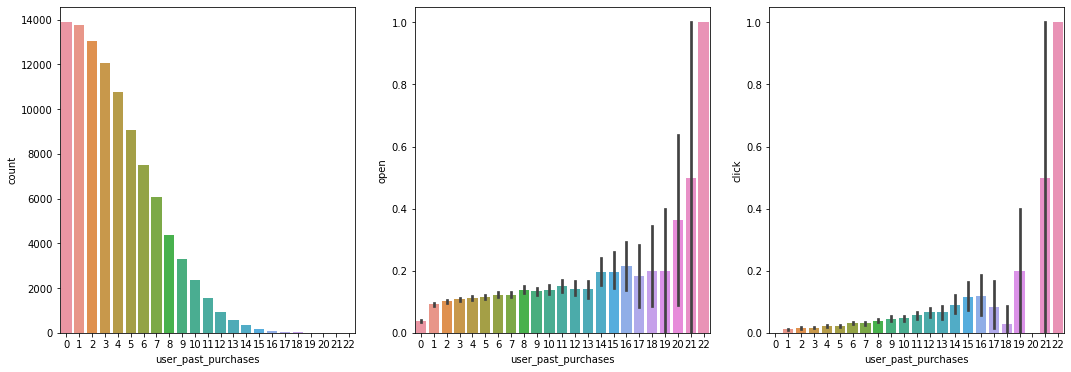

In [22]:
fig, axs = plt.subplots(1, 3, figsize = (18,6))

sns.countplot(x = "user_past_purchases", data = email, ax = axs[0])
sns.barplot(x = "user_past_purchases", y = "open", data = email, ax = axs[1])
sns.barplot(x = "user_past_purchases", y = "click", data = email, ax = axs[2])

plt.show()

Model

In [23]:
email

,email_id,email_text,email_version,hour,weekday,user_country,user_past_purchases,open,click
0,85120,short_email,personalized,2,Sunday,US,5,0.0,0.0
1,966622,long_email,personalized,12,Sunday,UK,2,1.0,1.0
2,777221,long_email,personalized,11,Wednesday,US,2,0.0,0.0
3,493711,short_email,generic,6,Monday,UK,1,0.0,0.0
4,106887,long_email,generic,14,Monday,US,6,0.0,0.0
...,...,...,...,...,...,...,...,...,...
99995,803504,short_email,personalized,4,Monday,US,5,0.0,0.0
99996,899722,long_email,personalized,7,Saturday,US,1,0.0,0.0
99997,449610,long_email,personalized,11,Saturday,UK,6,0.0,0.0
99998,72497,short_email,generic,10,Monday,UK,0,0.0,0.0


In [24]:
h2o.init()
h2o.remove_all()

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,13 mins 56 secs
H2O_cluster_timezone:,America/Indiana/Indianapolis
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.32.0.2
H2O_cluster_version_age:,12 days
H2O_cluster_name:,H2O_from_python_haorzeng_t3ibu2
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.542 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


In [26]:
h2o_df = H2OFrame(email)
h2o_df["click"] = h2o_df["click"].asfactor()

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [27]:
h2o_df.summary()

,email_id,email_text,email_version,hour,weekday,user_country,user_past_purchases,open,click
type,int,enum,enum,int,enum,enum,int,int,enum
mins,8.0,,,1.0,,,0.0,0.0,
mean,498690.1961600017,,,9.059300000000105,,,3.8784500000000186,0.10345,
maxs,999998.0,,,24.0,,,22.0,1.0,
sigma,289230.72753429407,,,4.439637441706958,,,3.1961097835771426,0.3045472459081676,
zeros,0,,,0,,,13877,89655,
missing,0,0,0,0,0,0,0,0,0
0,85120.0,short_email,personalized,2.0,Sunday,US,5.0,0.0,0
1,966622.0,long_email,personalized,12.0,Sunday,UK,2.0,1.0,1
2,777221.0,long_email,personalized,11.0,Wednesday,US,2.0,0.0,0


In [30]:
strat_split = h2o_df["click"].stratified_split(test_frac = 0.25)

train = h2o_df[strat_split == "train"]
test = h2o_df[strat_split == "test"]

features = ['email_text', 'email_version', 'hour', 'weekday', 'user_country', 'user_past_purchases']
target = "click"

In [31]:
model = H2ORandomForestEstimator(balance_classes = True)
model.train(x = features, y = target, training_frame = train)

drf Model Build progress: |███████████████████████████████████████████████| 100%


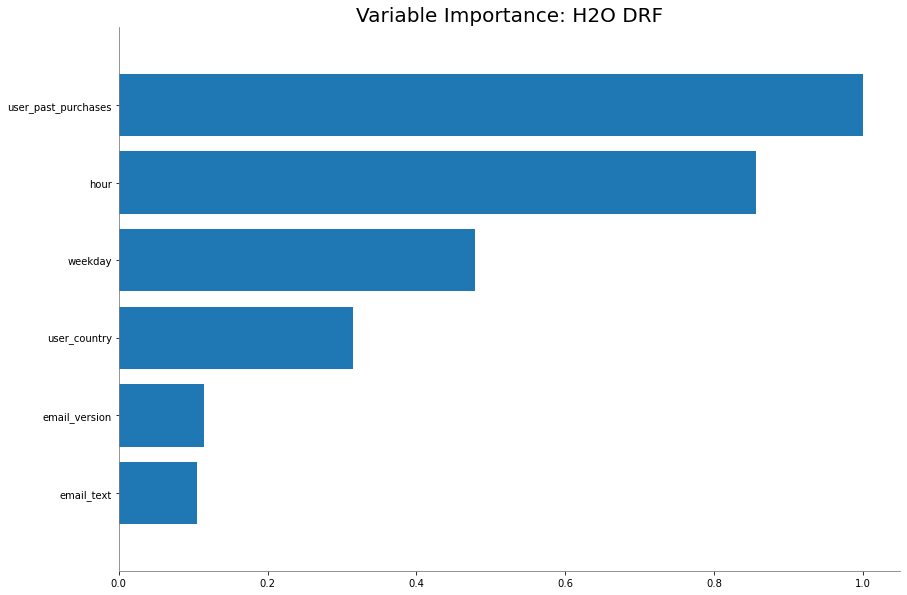

In [34]:
_ = model.varimp_plot()

In [51]:
train_true = train.as_data_frame()["click"]
test_true = test.as_data_frame()["click"]
train_pred = model.predict(train).as_data_frame()["p1"]
test_pred = model.predict(test).as_data_frame()["p1"]

drf prediction progress: |████████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%


In [53]:
print(classification_report(test_true, (test_pred>0.5).astype(int)))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99     24470
           1       0.00      0.00      0.00       530

    accuracy                           0.98     25000
   macro avg       0.49      0.50      0.49     25000
weighted avg       0.96      0.98      0.97     25000



In [73]:
test_fpr, test_tpr, test_thresh = roc_curve(test_true, test_pred)
train_fpr, train_tpr, train_thresh = roc_curve(train_true, train_pred)

No handles with labels found to put in legend.


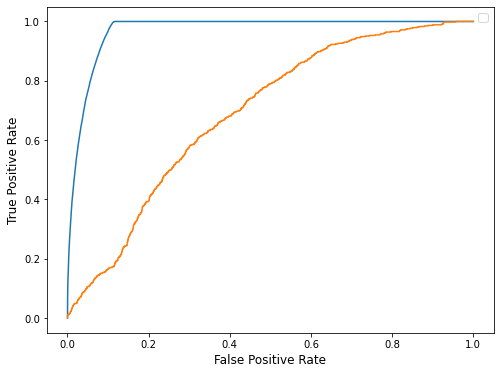

In [75]:
# ROC curves
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(train_fpr, train_tpr)
ax.plot(test_fpr, test_tpr)
ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.legend(fontsize=12)
plt.show()

In [87]:
print(classification_report(train_true, (train_pred>0.02143389361115466).astype(int)))

              precision    recall  f1-score   support

           0       1.00      0.89      0.94     73411
           1       0.16      1.00      0.28      1589

    accuracy                           0.89     75000
   macro avg       0.58      0.94      0.61     75000
weighted avg       0.98      0.89      0.93     75000



In [86]:
print(classification_report(test_true, (test_pred>0.02143389361115466).astype(int)))

              precision    recall  f1-score   support

           0       0.98      0.88      0.93     24470
           1       0.03      0.18      0.06       530

    accuracy                           0.87     25000
   macro avg       0.51      0.53      0.49     25000
weighted avg       0.96      0.87      0.91     25000



In [88]:
h2o.cluster().shutdown()

H2O session _sid_a42e closed.
